# 7. Bioinformatics Data Analysis — Expanded (EN)

**Why this matters:** In bioinformatics, you routinely convert raw files (FASTA/FASTQ, mzML, CSV/TSV feature tables) into tidy matrices for statistics and visualization. This notebook gives a **practical, hands‑on workflow** with *plain Python fallbacks* and optional `pandas/matplotlib/scikit‑learn` cells when available.

**You will learn to:**
- Ingest common bio data (CSV/TSV + minimal FASTA) into a consistent matrix form
- Perform quick **QC** (missingness, duplicates, outliers—lightweight)
- Apply **normalization & scaling** (log, min‑max, z‑score) and **batch‑like effects (toy)**
- Do **simple statistics** (fold‑change, t‑test using NumPy if present)
- Run **PCA** (if NumPy/sklearn available)
- Visualize distributions & profiles (single‑chart examples)
- Work through **three concrete use cases**: metabolomics, RNA‑seq, and microbiome

## A. Data model & file formats (practical view)

- **Samples × Features matrix**: rows = samples, columns = features (genes, peaks, OTUs, peptides).  
- **Metadata**: a small table describing samples (e.g., condition, batch).  
- **Common text formats**: CSV, TSV; keep an id column (e.g., `sample`) and use plain ASCII headers.

Minimal conventions used here:
- A table has a first column `sample` and feature columns `F1, F2, ...` or `gene_...`, `OTU_...`.  
- Missing numeric entries default to `0.0` or `None` depending on context.

## B. Utility functions (pure Python)

In [15]:
import csv, math, statistics
from typing import List, Dict, Iterable

def read_table(path: str) -> list[dict]:
    with open(path, newline='', encoding='utf-8') as f:
        return list(csv.DictReader(f))

def write_table(path: str, rows: list[dict], fieldnames: list[str]):
    with open(path, 'w', newline='', encoding='utf-8') as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader(); w.writerows(rows)

def to_matrix(rows: list[dict], features: list[str]) -> list[list[float]]:
    X = []
    for r in rows:
        X.append([float(r.get(f, 0.0) or 0.0) for f in features])
    return X

def minmax_norm(X: List[List[float]]) -> List[List[float]]:
    cols = list(zip(*X))
    mins = [min(c) for c in cols]
    maxs = [max(c) for c in cols]
    Y = []
    for row in X:
        Y.append([(x - mn) / (mx - mn) if mx != mn else 0.0
                  for x, mn, mx in zip(row, mins, maxs)])
    return Y

def zscore_cols(X: List[List[float]]) -> List[List[float]]:
    cols = list(zip(*X))
    means = [statistics.fmean(c) for c in cols]
    stdevs = [statistics.pstdev(c) for c in cols]
    Y = []
    for row in X:
        Y.append([(x-m)/s if s>0 else 0.0 for x,m,s in zip(row,means,stdevs)])
    return Y

def log1p(X: List[List[float]]) -> List[List[float]]:
    return [[math.log1p(x) for x in row] for row in X]

def row_sums(X: List[List[float]]) -> List[float]:
    return [sum(row) for row in X]

def relative_rows(X: List[List[float]]) -> List[List[float]]:
    Y = []
    for row in X:
        s = sum(row) or 1.0
        Y.append([x/s for x in row])
    return Y

## C. Quick QC checks

In [16]:
def missingness(rows: list[dict], features: list[str]) -> float:
    total = len(rows)*len(features) or 1
    miss = 0
    for r in rows:
        for f in features:
            v = r.get(f, "")
            if v in ("", None):
                miss += 1
    return miss/total

def duplicate_samples(rows: list[dict]) -> list[str]:
    seen, dups = set(), []
    for r in rows:
        sid = r.get("sample")
        if sid in seen:
            dups.append(sid)
        seen.add(sid)
    return dups

def feature_outliers_z(X: list[list[float]], thr: float = 3.5) -> dict[int,int]:
    cols = list(zip(*X))
    out = {}
    for j, col in enumerate(cols):
        m = statistics.fmean(col)
        s = statistics.pstdev(col) or 1.0
        cnt = sum(1 for x in col if abs((x-m)/s) > thr)
        out[j] = cnt
    return out

## D. Optional: pandas/matplotlib quick looks (if available)

In [17]:
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    print("pandas/matplotlib available ✅")
except Exception as e:
    print("pandas/matplotlib not available:", e)

pandas/matplotlib available ✅


## Use Case 1 — Metabolomics: Normalize & PCA (toy)

In [18]:
# 1) Generate table
import random, pathlib, csv
random.seed(42)
features = [f"F{i}" for i in range(1,7)]
rows = []
for i in range(6):
    base = random.uniform(100, 1000)
    vals = {f: round(base*random.uniform(0.5, 1.5), 2) for f in features}
    rows.append({"sample": f"S{i+1}", **vals})
path = pathlib.Path("metabolomics.csv")
with path.open("w", newline='', encoding='utf-8') as f:
    w = csv.DictWriter(f, fieldnames=["sample", *features])
    w.writeheader(); w.writerows(rows)
print(path.read_text().splitlines()[:4], "...", sep="\n")

['sample,F1,F2,F3,F4,F5,F6', 'S1,354.64,523.52,488.52,835.22,794.84,940.4', 'S2,164.33,94.43,128.09,179.2,93.85,124.56', 'S3,715.68,493.43,746.03,896.82,346.9,894.35']
...


In [19]:
# 2) Load and normalize
rows = read_table("metabolomics.csv")
X = to_matrix(rows, features)
tic = row_sums(X)
X_rel = relative_rows(X)          # TIC normalize
X_log = log1p(X_rel)              # log1p to reduce skew
X_std = zscore_cols(X_log)        # z-score per feature

print("TIC first 3:", [round(t,2) for t in tic[:3]])
print("Row sum after TIC normalize:", [round(sum(r),3) for r in X_rel[:3]])

TIC first 3: [3937.14, 784.46, 4093.21]
Row sum after TIC normalize: [1.0, 1.0, 1.0]


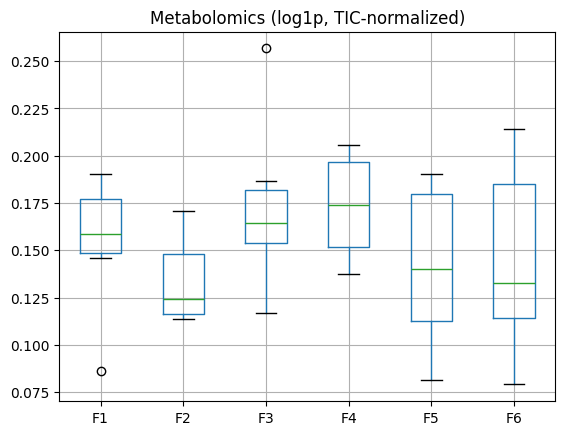

In [20]:
# 3) Optional boxplot
try:
    import pandas as pd, matplotlib.pyplot as plt
    df = pd.DataFrame(X_log, index=[r["sample"] for r in rows], columns=features)
    ax = df.boxplot(return_type=None)
    plt.title("Metabolomics (log1p, TIC-normalized)")
    plt.show()
except Exception as e:
    print("pandas/matplotlib not available:", e)

Explained variance ratio: [0.50597469 0.35888208]


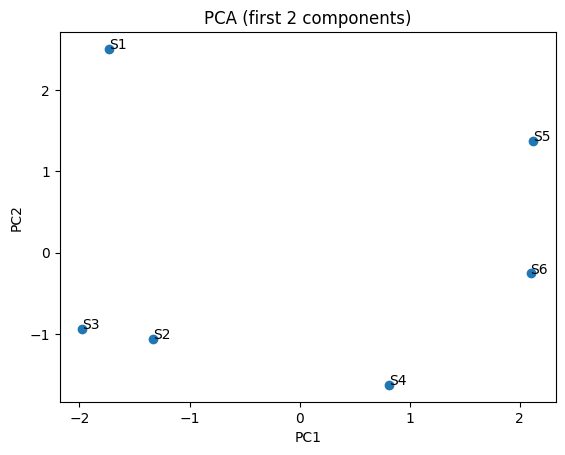

In [21]:
# 4) PCA optional
try:
    import numpy as np
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    Xn = np.array(X_std)
    pca = PCA(n_components=2, random_state=0)
    PCs = pca.fit_transform(Xn)
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    plt.scatter(PCs[:,0], PCs[:,1])
    for i, r in enumerate(rows):
        plt.text(PCs[i,0], PCs[i,1], r["sample"])
    plt.title("PCA (first 2 components)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()
except Exception as e:
    print("NumPy/sklearn/matplotlib not available:", e)

## Use Case 2 — RNA‑seq: Counts → TPM → log transform + simple DE (toy)

In [22]:
import random, csv, pathlib, math

random.seed(0)
G = [f"gene_{i:03d}" for i in range(1, 201)]
length_kb = {g: random.uniform(0.5, 3.0) for g in G}

samples = [f"C{i}" for i in range(1,4)] + [f"T{i}" for i in range(1,4)]
rows = []
for s in samples:
    counts = {g: random.randint(50, 2000) for g in G}
    if s.startswith("T"):
        for g in G[:10]:
            counts[g] = int(counts[g] * random.uniform(1.5, 3.0))
    rows.append({"sample": s, **counts})

csv_path = pathlib.Path("rnaseq_counts.csv")
with csv_path.open("w", newline='', encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["sample", *G])
    w.writeheader(); w.writerows(rows)
print("Wrote rnaseq_counts.csv with", len(rows), "samples and", len(G), "genes")

Wrote rnaseq_counts.csv with 6 samples and 200 genes


In [23]:
# Counts -> TPM (toy) -> log1p
rows = read_table("rnaseq_counts.csv")
X = to_matrix(rows, G)
# RPK
RPK = []
for row in X:
    RPK.append([x/(length_kb[g] or 1.0) for x,g in zip(row, G)])
# scale to TPM
scale = [sum(r) or 1.0 for r in RPK]
TPM = [[x/s*1e6 for x,s in zip(r,scale)] for r in RPK]
LOG = log1p(TPM)
print("Example TPM sums (first 3):", [round(sum(r),2) for r in TPM[:3]])

Example TPM sums (first 3): [21400.81, 20684.94, 24315.94]


In [24]:
# Simple DE: log2FC and naive t-test (if NumPy available)
try:
    import numpy as np
    from math import log2
    import statistics
    import math

    X = np.array(LOG)  # samples x genes (log1p(TPM))
    ctrl_idx = [i for i,s in enumerate([r["sample"] for r in rows]) if s.startswith("C")]
    trt_idx  = [i for i,s in enumerate([r["sample"] for r in rows]) if s.startswith("T")]

    ctrl = X[ctrl_idx, :]
    trt  = X[trt_idx, :]

    mean_ctrl = ctrl.mean(axis=0)
    mean_trt  = trt.mean(axis=0)
    log2fc = (mean_trt - mean_ctrl) / math.log(2)  # since LOG is log1p base e

    def welch_t(a, b):
        ma, mb = a.mean(), b.mean()
        va, vb = a.var(ddof=1), b.var(ddof=1)
        na, nb = len(a), len(b)
        t = (mb - ma) / ((va/na + vb/nb)**0.5 + 1e-12)
        return t

    tvals = np.array([welch_t(trt[:,j], ctrl[:,j]) for j in range(X.shape[1])])

    order = np.argsort(-np.abs(log2fc))[:5]
    top = [(G[j], float(log2fc[j]), float(tvals[j])) for j in order]
    print("Top by |log2FC| (gene, log2FC, t):")
    for g,lfc,t in top:
        print(g, round(lfc,2), round(t,2))
except Exception as e:
    print("NumPy not available for DE demo:", e)

Top by |log2FC| (gene, log2FC, t):
gene_002 3.43 -7.51
gene_005 2.26 -10.25
gene_006 1.8 -1.86
gene_001 1.3 -1.09
gene_003 1.2 -1.34


## Use Case 3 — Microbiome: Relative abundance & Shannon diversity

In [25]:
# Create tiny OTU table
import csv, pathlib, math
taxa = ["Escherichia", "Bacteroides", "Lactobacillus", "Prevotella", "Faecalibacterium"]
samples = ["S1","S2","S3","S4"]
rows = []
for i,s in enumerate(samples):
    row = {"sample": s}
    for t in taxa:
        row[t] = (i+1)*10 if (hash(t+str(i)) % 3) else (i+1)*50
    rows.append(row)

otu_path = pathlib.Path("otu_counts.csv")
with otu_path.open("w", newline='', encoding="utf-8") as f:
    w = csv.DictWriter(f, fieldnames=["sample", *taxa])
    w.writeheader(); w.writerows(rows)
print("OTU table saved:", otu_path)

OTU table saved: otu_counts.csv


In [26]:
# Relative abundance and Shannon
def shannon(p: Iterable[float]) -> float:
    s = 0.0
    for x in p:
        if x > 0:
            s -= x * math.log(x)
    return s

rows = read_table("otu_counts.csv")
X = to_matrix(rows, taxa)
X_rel = relative_rows(X)
H = [shannon(row) for row in X_rel]

for r,h in zip(rows, H):
    print(r["sample"], "Shannon H=", round(h,3))

S1 Shannon H= 1.327
S2 Shannon H= 1.609
S3 Shannon H= 1.303
S4 Shannon H= 1.609


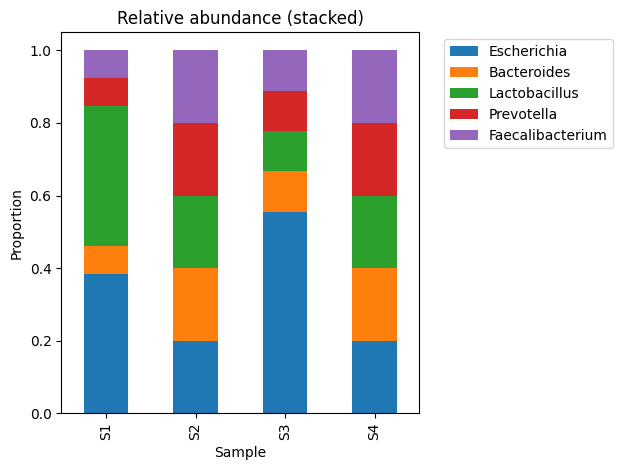

In [27]:
# Optional stacked bar of top taxa
try:
    import pandas as pd, matplotlib.pyplot as plt
    df = pd.DataFrame(X_rel, index=[r["sample"] for r in rows], columns=taxa)
    df.plot(kind="bar", stacked=True)
    plt.title("Relative abundance (stacked)")
    plt.ylabel("Proportion")
    plt.xlabel("Sample")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("pandas/matplotlib not available:", e)

## Appendix — Minimal FASTA parsing + sequence metrics

In [28]:
def read_fasta(path):
    name, seq = None, []
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('>'):
                if name:
                    yield (name, ''.join(seq))
                name = line[1:]
                seq = []
            else:
                seq.append(line)
    if name:
        yield (name, ''.join(seq))

# demo
open("tiny.fa","w").write(">s1\nATGCGTACGT\n>s2\nATTTGGCCAA\n")
for name, seq in read_fasta("tiny.fa"):
    gc = (seq.count('G')+seq.count('C'))/len(seq)
    print(name, "len", len(seq), "GC%", round(gc*100,1))

s1 len 10 GC% 50.0
s2 len 10 GC% 40.0


## Exercises

1. **QC dashboard**: Compute and print missingness, duplicate samples, and top‑5 features with most outliers (by `feature_outliers_z`).  
2. **Metabolomics**: After `zscore_cols`, compute **cosine similarity** between pairs of samples and find the most similar pair.  
3. **RNA‑seq**: Modify the DE demo to also compute **Benjamini‑Hochberg FDR** if NumPy is available.  
4. **Microbiome**: Add **Shannon evenness** (`H/log(S)`) and identify the sample with the highest evenness.  
5. **General**: Write a function that joins two CSV tables on `sample` and returns a merged matrix of features.